In [ ]:
# Downloading the codebase
!gdown 1Dom7tohfPJOfryscj6TsdTrxlqJwKCb4

Mounted at /content/drive


In [ ]:
!tar -xvzf Expanding-on-Lexical-Stylistic-Features-modified.tar.gz

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.dummy import DummyClassifier

In [ ]:
!python -m spacy download en_core_web_md

2023-12-20 09:41:22.344269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 09:41:22.344312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 09:41:22.345603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 09:41:23.434146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
!pip install transformers

In [ ]:
train_data_path = "Expanding-on-Lexical-Stylistic-Features-modified/data/complexity/SimplePPDB/train.csv"

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import csv
import spacy
import numpy as np
from sklearn.linear_model import LogisticRegression

In [ ]:
def load_dataset(dataset_frn):
    if dataset_frn.endswith('.csv'):
        delimiter = ','
    elif dataset_frn.endswith('.tsv'):
        delimiter = '\t'
    else:
        raise ValueError("Unknown dataset file format.")
    with open(dataset_frn, 'r', encoding='utf-8') as dataset_fr:
        reader = csv.DictReader(dataset_fr, delimiter=delimiter)
        rows = []
        for row in reader:
            rows.append(row)
    return rows

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
def parse_batch(texts):
    '''Tokenize and do POS taggging on a list of texts'''
    docs = list(nlp.pipe(texts))
    tokens_for_docs = []
    pos_tags_for_docs = []
    for doc in docs:
        tokens = [token.text for token in doc]
        pos_tags = [token.pos_ for token in doc]
        tokens_for_docs.append(tokens)
        pos_tags_for_docs.append(pos_tags)
    return tokens_for_docs, pos_tags_for_docs

In [ ]:
LM = AutoModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def get_embeddings(texts):
    '''Get the embeddings of a list of texts.
	Args:
		texts (list): a list of texts, each of which is a list of tokens
	Returns:
		texts_embeddings (list): a list of tensors, each of shape (n_tokens, embedding_dim)
	'''
    global LM, tokenizer
    layer = -1
    inputs = tokenizer(texts, is_split_into_words=True, padding=True, return_tensors="pt", truncation=True).to(device)
    # get the embeddings
    LM.eval()
    with torch.no_grad():
        # process one batch at a time
        texts_embeddings = []
        outputs = LM(**inputs, output_hidden_states=True)
        # get the embeddings of the specified layer
        # print(f"Number of layers in {self.LM_names[feature]}: {len(outputs.hidden_states)}")
        token_embeddings = outputs.hidden_states[layer]
        # for each text, get the averaged token embeddings
        for text_id, token_embedding in enumerate(token_embeddings):
            # align the token embeddings with the pre-split tokens
            # if a pre-split token is then split into multiple wordpieces, average the embeddings of the wordpieces
            aligned_token_embedding = []
            transformer_to_presplit_word_id_mapping = inputs.word_ids(batch_index=text_id)
            previous_word_idx = -1
            current_token_wordpieces_embeddings = []

            for transformer_token_id, presplit_word_id in enumerate(transformer_to_presplit_word_id_mapping):
                if presplit_word_id is None:
                    continue
                elif presplit_word_id != previous_word_idx:  # new word
                    # add the previous token
                    if current_token_wordpieces_embeddings:
                        current_token_wordpieces_embeddings = torch.stack(current_token_wordpieces_embeddings)
                        aligned_token_embedding.append(torch.mean(current_token_wordpieces_embeddings, dim=0))
                    # start a new token
                    current_token_wordpieces_embeddings = [token_embedding[transformer_token_id]]
                    if presplit_word_id != previous_word_idx + 1: # new token id is not continuous
                        # append zero embeddings for missing tokens
                        for _ in range(presplit_word_id - previous_word_idx - 1):
                            aligned_token_embedding.append(torch.zeros(LM.config.hidden_size).to(device))
                else: # same word
                    current_token_wordpieces_embeddings.append(token_embedding[transformer_token_id])
                previous_word_idx = presplit_word_id

            # add the last token
            current_token_wordpieces_embeddings = torch.stack(current_token_wordpieces_embeddings)
            aligned_token_embedding.append(torch.mean(current_token_wordpieces_embeddings, dim=0))
            n_tokens = len(texts[text_id])
            for _ in range(n_tokens - previous_word_idx - 1):
                aligned_token_embedding.append(torch.zeros(LM.config.hidden_size).to(device))
            aligned_token_embedding = torch.stack(aligned_token_embedding)

            # add to the list of sentence embeddings
            texts_embeddings.append(aligned_token_embedding)

				# texts_embeddings = torch.stack(texts_embeddings)
        return texts_embeddings

In [ ]:
def get_feature_batch(texts):
    ''' Predict the target feature for a batch of texts.

    :param texts: a list of texts, each of which is a string.
    :param feature: the target feature to predict, which can be "complexity", "formality", "intensity", or "figurativeness".

    :return: features_for_texts: a tensor of shape [n_texts, n_dim] representing the feature scores for each text, where n_dim is the dimension of the feature.
    '''
    # tokenize and POS tag the texts
    tokens_for_texts, pos_tags_for_texts = parse_batch(texts)
    features_for_texts = []

    # get the average token embeddings as sentence embedding
    # get the raw token embeddings
    # get the average token embeddings as sentence embedding
    for tokens_for_text in tokens_for_texts:
        token_embs = get_embeddings([tokens_for_text])[0] # shape: [n_tokens, emb_dim]
        mean_text_emb = torch.mean(token_embs, dim=0) # shape: [emb_dim]
        # compute the generalized similarity between the text embedding and the dvec
        # cos_sim = cosine_similarity(mean_text_emb, self.dvecs[feature].unsqueeze(0)).squeeze(0)
        features_for_text = [mean_text_emb]
        features_for_text = torch.stack(features_for_text)
        features_for_texts.append(features_for_text)
    features_for_texts = torch.stack(features_for_texts)
    return features_for_texts

In [ ]:
import pickle
def load_dvecs(path, isotropy_path=None):
    with open(path, 'rb') as dvec_fr:
        dvec = pickle.load(dvec_fr).to(device)
    if isotropy_path is not None:
        with open(isotropy_path, 'rb') as isotropy_fr:
            isotropy_vecs = pickle.load(isotropy_fr)
        return dvec, isotropy_vecs
    return dvec

# Test Results Visualisation and Analysis

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [ ]:
test_data_path = "Expanding-on-Lexical-Stylistic-Features-modified/data/complexity/SimplePPDB/test.csv"

In [ ]:
test_data = load_dataset(test_data_path)
# Make predictions
predicted_class = "simple" # we want to identify the simpler one in two texts

text0s_test = []
text1s_test = []
gold_labels_test = []
for example in test_data:
  text0, text1, gold = example["0"], example["1"], example["gold_simple"]
  text0s_test.append(text0)
  text1s_test.append(text1)
  gold_labels_test.append(int(gold))
  #pred = model.compare_complexity(text0=text0, text1=text1)
  #pred_row = example.copy()
  #pred_row[f"pred_{predicted_class}"] = pred
  #prediction_rows.append(pred_row)

In [ ]:
embeddings0_test = get_feature_batch(text0s_test)
embeddings1_test = get_feature_batch(text1s_test)
embeddings0_test = embeddings0_test.reshape(embeddings0_test.shape[0], -1).cpu().detach().numpy()
embeddings1_test = embeddings1_test.reshape(embeddings1_test.shape[0], -1).cpu().detach().numpy()

In [ ]:
embeddings_test = np.concatenate([embeddings0_test[:300], embeddings1_test[:300]], axis=0)

In [ ]:
tsne_test = TSNE(random_state=10000)

In [ ]:
visualisation_embeddings_test = tsne_test.fit_transform(embeddings_test)

In [ ]:
gold_labels_test = np.array(gold_labels_test)

In [ ]:
simple_embeddings = visualisation_embeddings_test[:300, gold_labels_test[:300]]

In [ ]:
complex_embeddings = visualisation_embeddings_test[300:, 1 - gold_labels_test[:300]]

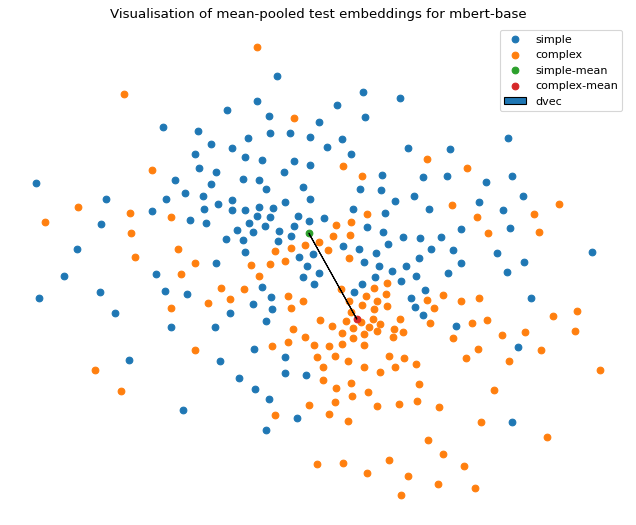

In [ ]:
figure(figsize=(10, 8), dpi=80)
plt.scatter(simple_embeddings[:, 0], simple_embeddings[:, 1], label="simple")
plt.scatter(complex_embeddings[:, 0], complex_embeddings[:, 1], label="complex")
plt.scatter(simple_embeddings[:, 0].mean(), simple_embeddings[:, 1].mean(), label="simple-mean")
plt.scatter(complex_embeddings[:, 0].mean(), complex_embeddings[:, 1].mean(), label="complex-mean")
plt.arrow(simple_embeddings[:, 0].mean(), simple_embeddings[:, 1].mean(), complex_embeddings[:, 0].mean() - simple_embeddings[:, 0].mean(),
          complex_embeddings[:, 1].mean() - simple_embeddings[:, 1].mean(), head_width=.15, label="dvec")
plt.legend()
_ = plt.title("Visualisation of mean-pooled test embeddings for mbert-base")
_ = plt.axis("off")

In [ ]:
dvec_path = "Expanding-on-Lexical-Stylistic-Features-modified/data/complexity/dvecs/bert-base-multilingual-uncased_-1_layeragg_seeds7_normalized_dvec.pkl"
isotropy_path = "Expanding-on-Lexical-Stylistic-Features-modified/data/complexity/dvecs/bert-base-multilingual-uncased_-1_layeragg_seeds7_normalized_isovec.pkl"
dvec, isotropy_vecs = load_dvecs(dvec_path, isotropy_path)
isotropy_vecs = isotropy_vecs['complexity']

In [ ]:
# Normalize isotropy vectors
mean = isotropy_vecs['mean'].detach().cpu().numpy()
std = isotropy_vecs['std'].detach().cpu().numpy()
embeddings0_test_normalized = (embeddings0_test - mean) / std
embeddings1_test_normalized = (embeddings1_test - mean) / std

In [ ]:
embeddings_test_normalized = np.concatenate([embeddings0_test_normalized[:300], embeddings1_test_normalized[:300]], axis=0)

In [ ]:
tsne_test_normalized = TSNE(random_state=10000)

In [ ]:
visualisation_embeddings_test_normalized = tsne_test_normalized.fit_transform(embeddings_test_normalized)

In [ ]:
simple_embeddings = visualisation_embeddings_test_normalized[:300, gold_labels_test[:300]]

In [ ]:
complex_embeddings = visualisation_embeddings_test_normalized[300:, 1 - gold_labels_test[:300]]

# Error Analysis

In [ ]:
cd "Expanding-on-Lexical-Stylistic-Features-modified/output_dir/complexity/SimplePPDB/test"

/content/drive/Shareddrives/CIS-5300-Project/Expanding-on-Lexical-Stylistic-Features-modified/output_dir/complexity/SimplePPDB/test


In [ ]:
predictions = pd.read_csv(model_name + ".csv")[:300]

In [ ]:
incorrect_predictions = predictions[predictions["pred_simple"] != predictions["gold_simple"]]

## Example-1

In [ ]:
idx = incorrect_predictions.index[0]
predictions.iloc[idx]

gold_simple    0
pred_simple    1
Name: 4, dtype: int64

In [ ]:
# Actual simple / Predicted complex
text0s_test[idx]

'standard'

In [ ]:
# Actual complex / Predicted simple
text1s_test[idx]

'norma'

## Example-2

In [ ]:
idx = incorrect_predictions.index[2]
predictions.iloc[idx]

gold_simple    1
pred_simple    0
Name: 16, dtype: int64

In [ ]:
# Actual simple / Predicted complex
text1s_test[idx]

'disturbs'

In [ ]:
# Actual complex / Predicted simple
text0s_test[idx]

'impedes'

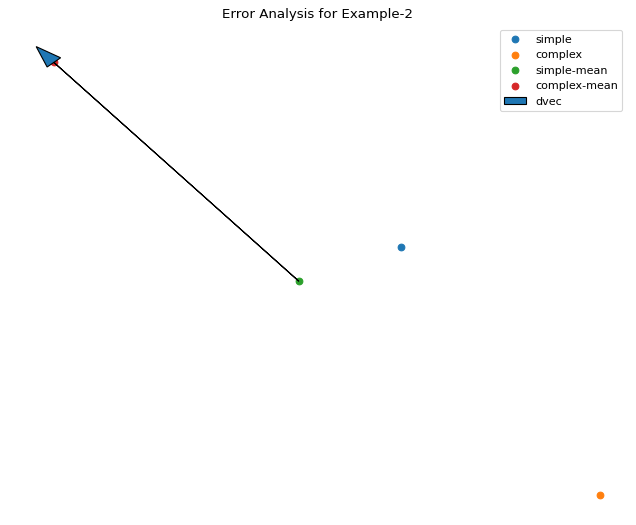

In [ ]:
figure(figsize=(10, 8), dpi=80)
plt.scatter(simple_embeddings[idx, 0], simple_embeddings[idx, 1], label="simple")
plt.scatter(complex_embeddings[idx, 0], complex_embeddings[idx, 1], label="complex")
plt.scatter(simple_embeddings[:, 0].mean(), simple_embeddings[:, 1].mean(), label="simple-mean")
plt.scatter(complex_embeddings[:, 0].mean(), complex_embeddings[:, 1].mean(), label="complex-mean")
plt.arrow(simple_embeddings[:, 0].mean(), simple_embeddings[:, 1].mean(), complex_embeddings[:, 0].mean() - simple_embeddings[:, 0].mean(),
          complex_embeddings[:, 1].mean() - simple_embeddings[:, 1].mean(), head_width=.15, label="dvec")
plt.legend()
_ = plt.title("Error Analysis for Example-2")
_ = plt.axis("off")

## Example-3

In [ ]:
len(incorrect_predictions)

44

In [ ]:
idx = incorrect_predictions.index[5]
predictions.iloc[idx]

gold_simple    0
pred_simple    1
Name: 45, dtype: int64

In [ ]:
# Actual simple / Predicted complex
text0s_test[idx]

'minimize'

In [ ]:
# Actual complex / Predicted simple
text1s_test[idx]

'constrained'

In [ ]:
simple_embeddings.shape

(300, 300)

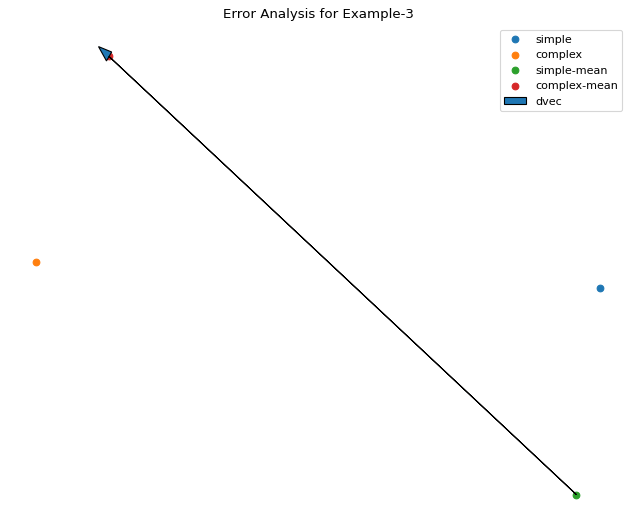

In [ ]:
figure(figsize=(10, 8), dpi=80)
plt.scatter(simple_embeddings[idx, 0], simple_embeddings[idx, 1], label="simple")
plt.scatter(complex_embeddings[idx, 0], complex_embeddings[idx, 1], label="complex")
plt.scatter(simple_embeddings[:, 0].mean(), simple_embeddings[:, 1].mean(), label="simple-mean")
plt.scatter(complex_embeddings[:, 0].mean(), complex_embeddings[:, 1].mean(), label="complex-mean")
plt.arrow(simple_embeddings[:, 0].mean(), simple_embeddings[:, 1].mean(), complex_embeddings[:, 0].mean() - simple_embeddings[:, 0].mean(),
          complex_embeddings[:, 1].mean() - simple_embeddings[:, 1].mean(), head_width=.15, label="dvec")
plt.legend()
_ = plt.title("Error Analysis for Example-3")
_ = plt.axis("off")